# Developing intuition with a library of models

While the helical random field and the IMAGINE are not fuly working, it is worth start developing intuition about SN shells. This notebook aims helping on this, constructing a library of models displaying different parameter choices.

## Model description

The model comprises a shell which develped on an medium which contained an initially uniform magnetic field $\vec{B}=(B_x, B_y, B_z)$ and a Gaussian random component with $\langle b \rangle=0$ and $b_{\rm rms} \propto B$.

The inital electron density distribution is also assumed to be uniform. The final cosmic ray distribution can *either* be proportional to the *final* electron density (i.e. CRs on the shell) or proportional to the *initial* thermal electorn distribution (i.e. uniform CRs).

## Basic setup

In [253]:
import os, sys
sys.path.append('../')

from shell import ShellModel, FieldTransformer
import shell.observable as obs
import numpy as np
import astropy.units as u
import matplotlib.pyplot as plt
import imagine as img
import shell.visualization as visu

We will use a common grid for all the calculations

In [254]:
L = 70*u.pc; N = 100

grid = img.UniformGrid(# coordinate values for edges of the grid box
                       box=[[-L,L],[-L,L],[-L,L]], 
                       # Grid resolution
                       resolution=[N, N, N])

The naive random field previously defined in notebook 4 is copied here, with some adjustments

In [256]:
from galmag.util import derive

def random_field(grid, Brms):
    """
    Generates a basic random field
    """
    mu = 0; sigma = 1
    # Defines a random vector potential 
    A_rnd = {} # Dictionary of vector components
    for i, c in enumerate(('x','y','z')):
        A_rnd[c] = np.random.normal(mu, sigma, grid.resolution.prod())
        A_rnd[c] = A_rnd[c].reshape(grid.resolution)

    # Prepares the derivatives to compute the curl
    dBi_dj ={}
    for i, c in enumerate(['x','y','z']):
        for j, d in enumerate(['x','y','z']):
            dj = (grid.box[j][-1]-grid.box[j][0])/float(grid.resolution[j])
            dBi_dj[c,d] = derive(A_rnd[c],dj, axis=j)

    # Computes the curl of A_rnd
    Brnd = {}        
    Brnd['x'] = dBi_dj['z','y'] -  dBi_dj['y','z']
    Brnd['y'] = dBi_dj['x','z'] -  dBi_dj['z','x']
    Brnd['z'] = dBi_dj['y','x'] -  dBi_dj['x','y']
    
    # Finds normalization factor  to obtain correct Brms
    norm = np.sqrt(np.mean([Brnd[k]**2 for k in Brnd]))
    f = Brms/norm/np.sqrt(3)
    
    return Brnd['x']*f, Brnd['y']*f,  Brnd['z']*f

Now, I will define a helper class which contains the full specficiation of the model and stores the relevant quantities during one particular evaluation. This is done in a very inefficient fashion, as clarity is the main goal.

In [282]:
muG = u.microgauss
from collections import defaultdict
import astropy.constants as c

class Model:
    """
    Helper class to make it easier to construct the model library
    """
    def __init__(self, grid, shell_parameters={}, ne=1*u.cm**-3, 
                 B_Brnd=1, B=[0*muG, 0*muG, 0*muG], 
                 cr_type ='thermal', ncr_ne=1,
                 freqs=[1.4*u.GHz, 2.7*u.GHz], #, 4.8*u.GHz, 10*u.GHz],
                 gamma=1):
        
            # Creates the shell model
            shell_dict = dict(V0=0.0153*u.pc/u.yr,
                              a=1.3, b=10, R=50*u.pc,
                              elapsed_time=1300*u.yr)
            shell_dict.update(shell_parameters)
            shell_model = ShellModel(**shell_dict)
        
            # Generates the field transformer
            field_transformer = FieldTransformer(grid, shell_model)
            
            # Initial density model
            n0 = ne*np.ones(grid.shape)
            
            # Initial large scale field model
            Bls = [Bi*np.ones(grid.shape) for Bi in B]
            
            # Initial random field model
            Brms = np.sqrt(np.mean(Bls[0]**2+Bls[1]**2+Bls[2]**2)) / B_Brnd
            Brnd = random_field(grid, Brms)
            
            # Total initial field
            B0 = [Bls_i + Brnd_i for Bls_i, Brnd_i in zip(Bls, Brnd)]
            
            # Computes final B and thermal electron density
            self.ne, [self.Bx, self.By, self.Bz] = field_transformer(n0, B0)
        
            # Cosmic ray model
            if cr_type == 'uniform':
                # Uniformly distributed cosmic rays
                self.ncr = ne*np.ones(grid.shape)*ncr_ne
            elif cr_type == 'thermal':
                # Cosmic ray density proportional to thermal electron density
                self.ncr = self.ne*ncr_ne
            else:
                raise ValueError('Available options: "thermal" or "uniform"')
        
            # Stores frequencies (converted to wavelenghts), grid, etc
            self.wavelengths = [(c.c/(f)).to(u.cm) for f in freqs]
            self.grid = grid
            self.gamma = gamma
            self._stokes = None
            self._Psi = None
            self._RM = None
            self._PI = None
            
    @property
    def Q(self):
        if self._stokes is None:
            self._compute_stokes()
        return self._stokes['Q']
    @property
    def U(self):
        if self._stokes is None:
            self._compute_stokes()
        return self._stokes['U']
    @property
    def I(self):
        if self._stokes is None:
            self._compute_stokes()
        return self._stokes['I']
    
    @property
    def Psi(self):
        if self._Psi is None:
            self._Psi = []
            for U, Q in zip(self.U, self.Q):
                # Computes Psi for all requested wavelengths
                self._Psi.append(obs.compute_Psi(U,Q))
        return self._Psi
    
    @property
    def PI(self):
        if self._PI is None:
            self._PI = []
            for U, Q in zip(self.U, self.Q):
                # Computes Psi for all requested wavelengths
                self._PI.append(np.sqrt(U**2+Q**2))
        return self._PI
    
    @property
    def RM(self):
        if self._RM is None:
            self._RM = []
            for Psi1, lambda1, Psi2, lambda2 in zip(self.Psi[:-1],
                                                    self.wavelengths[:-1],
                                                    self.Psi[1:],
                                                    self.wavelengths[1:]):
                self._RM.append(obs.compute_RM(Psi1, Psi2, lambda1, lambda2))
        return self._RM
    @property
    def B(self):
        """Shorthand for [Bx, By, Bz]"""
        return [self.Bx, self.By, self.Bz]
    
    def _compute_stokes(self):
        self._stokes = defaultdict(list)
        for wavelength in self.wavelengths:
            I, Q, U = obs.compute_stokes_parameters(self.grid, wavelength, 
                                                    self.Bx, self.By, self.Bz,
                                                    self.ne, self.ncr, 
                                                    self.gamma)
            self._stokes['I'].append(I)
            self._stokes['Q'].append(Q)
            self._stokes['U'].append(U)


Observables (e.g. Q) appear in lists (one item per input frequency) while physical quantities (e.g. Bx) not. 
Note that the RM property is computed combining 2 consecutive wavelengths. Thus , it contains less elements than, say, stokes Q. 

Let us test this

In [283]:
test_model = Model(grid, B=[1,0, 0.5]*muG)

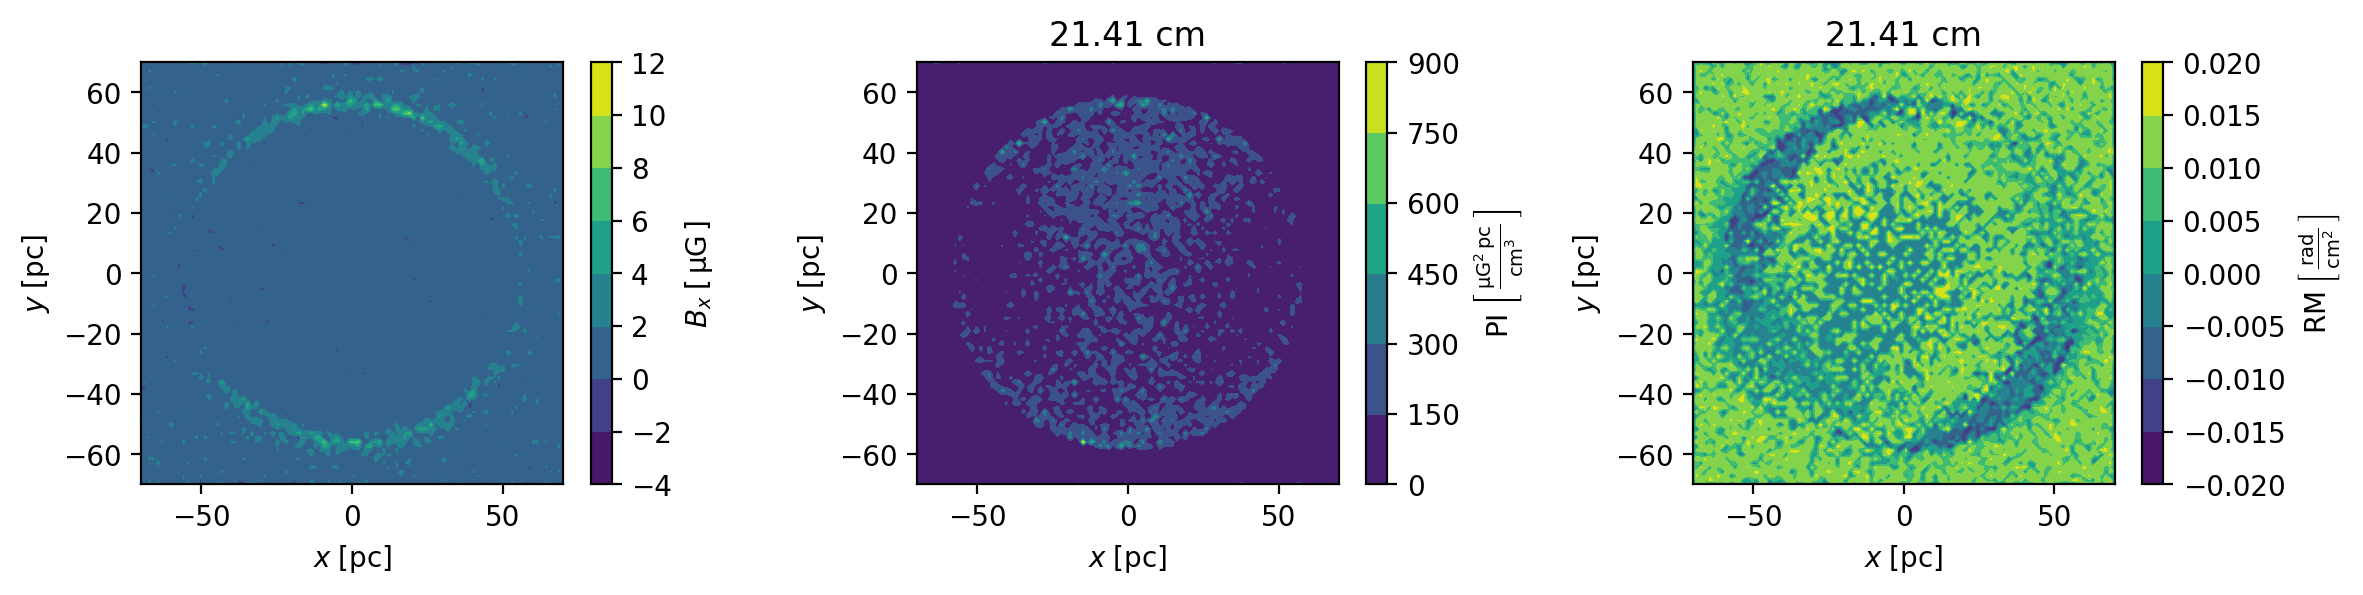

In [280]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,3),dpi=200)
visu.plot_scalar_xy(grid, test_model.Bx, name='B_x', ax=ax1)
visu.plot_scalar_xy(grid, test_model.PI[0], name=r'{\rm PI}', ax=ax2)
ax2.set_title(np.round(test_model.wavelengths[0], decimals=2))
visu.plot_scalar_xy(grid, test_model.RM[0], name=r'{\rm RM}', ax=ax3)
ax3.set_title(np.round(test_model.wavelengths[0], decimals=2))
plt.tight_layout()